In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
sobel_x = np.array([
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
],dtype='int32') 

sobel_y = np.array([
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
],dtype='int32')

gauss = np.array([
    [1/16,2/16,1/16],
    [2/16,4/16,2/16],
    [1/16,2/16,1/16]
],dtype='float64')

In [3]:
def grayscale(image):
    return cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

def convolve(image,kernel):
    
    image_height = image.shape[0]
    image_width = image.shape[1]
    kernel_height = kernel.shape[0]
    kernel_width = kernel.shape[1]
    pad_height = kernel.shape[0]//2
    pad_width = kernel.shape[1]//2
    
    result = np.empty(image.shape, dtype=np.float64)
    
    padded_image = np.pad(image,((pad_height,pad_height),(pad_width,pad_width)),mode='constant')
    
    for i in range(image_height):
        for j in range(image_width):
            roi = padded_image[i:i+kernel_height,j:j+kernel_width]
            result[i,j] = np.sum(roi*kernel)
    
    return result   

def sobel_filter(image):
    dx = convolve(image,sobel_x)
    dy = convolve(image,sobel_y)
    return dx,dy
    
def gaussian_filter(image):
    return convolve(image,gauss)

def harris_response(dx,dy):
    dx2,dy2,dxdy = np.square(dx),np.square(dy),dx*dy
    g_dx2,g_dy2,g_dxdy = gaussian_filter(dx2),gaussian_filter(dy2),gaussian_filter(dxdy)
    harris = g_dx2*g_dy2-np.square(g_dxdy)-0.035*np.square(g_dx2+g_dy2)
    return harris

def non_max_suppression(harris,threshold):
    harris_norm = cv2.normalize(harris,None,0,1, cv2.NORM_MINMAX)
    loc = np.where(harris_norm>=threshold)
    return loc

def draw_corners(img,loc):
    img_cpy = img.copy()
    for pt in zip(*loc[::-1]):
        cv2.circle(img_cpy,pt,2,(0,0,255),-1)
    return img_cpy

def harris(img,threshold=0.5):
    img_cpy = img.copy()
    img_gray = grayscale(img)
    dx,dy = sobel_filter(img_gray)
    harris = harris_response(dx,dy)
    loc = non_max_suppression(harris,threshold)
    img_with_corners = draw_corners(img_cpy,loc)
    return img_with_corners

def harris_cv(img,threshold=0.01):
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    corners = cv2.cornerHarris(img_gray,2,3,0.04)
    img_with_corners = img.copy()
    img_with_corners[corners>threshold*corners.max()]=[0,0,255]
    return img_with_corners

def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder,filename)
        _,ext = os.path.splitext(file_path)
        ext = ext.lower()
        if ext in ['.jpg','.jpeg','.png']:
            img = cv2.imread(file_path)
            if img is not None:
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                images.append(img)
    return images                

In [4]:
images_folder_dir = "/kaggle/input/cvassign1/Question 1-20240326T173034Z-001/Question 1"
images = load_images(images_folder_dir)

In [5]:
corners_custom = []
corners_cv = []
for i in range(len(images)):
    img_with_corners_custom = harris(images[i])
    img_with_corners_cv = harris_cv(images[i])
    corners_custom.append(img_with_corners_custom)
    corners_cv.append(img_with_corners_cv)

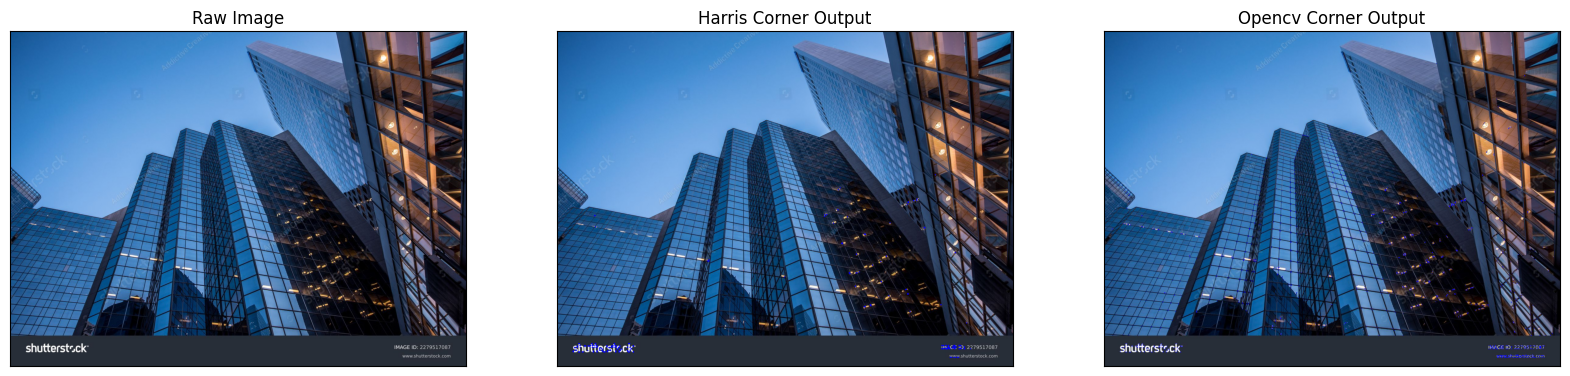

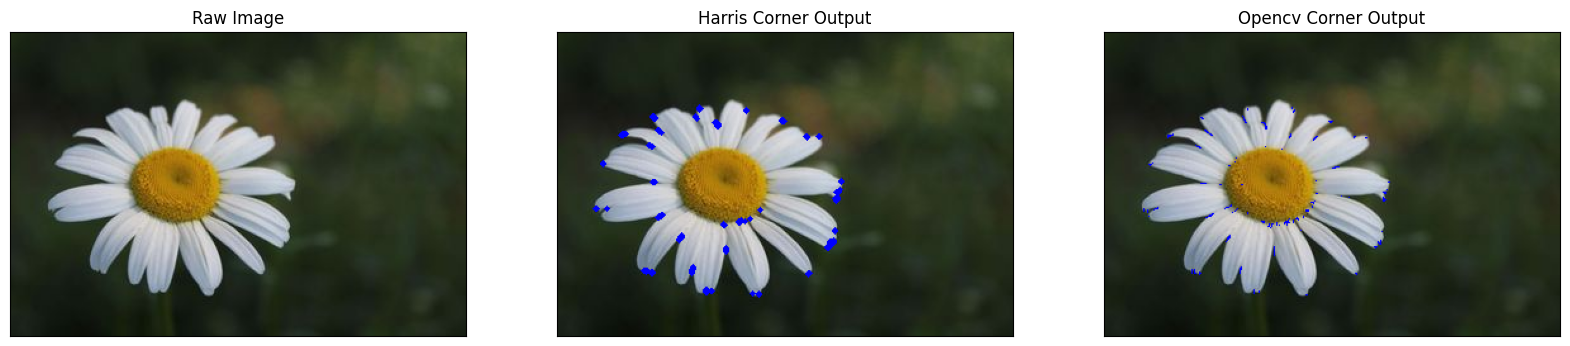

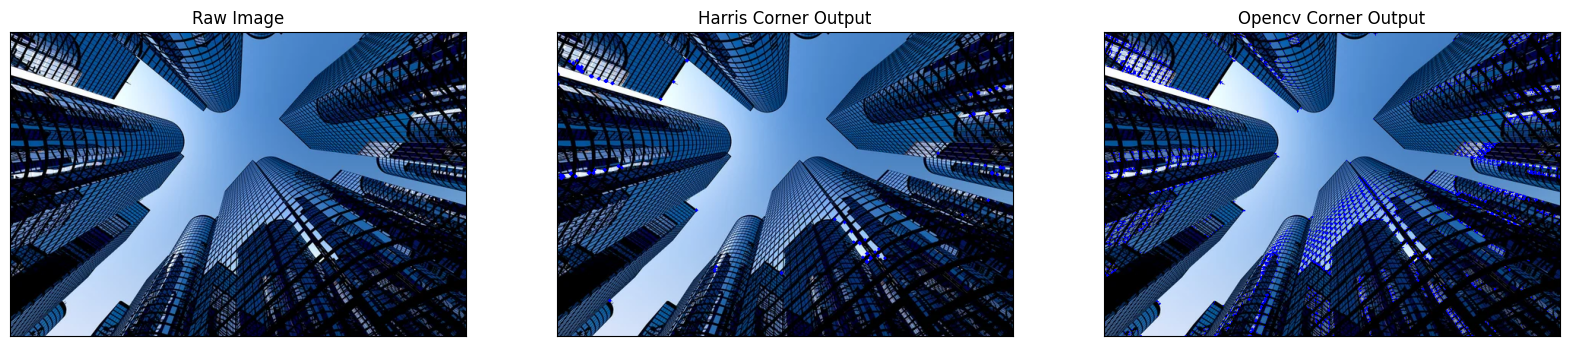

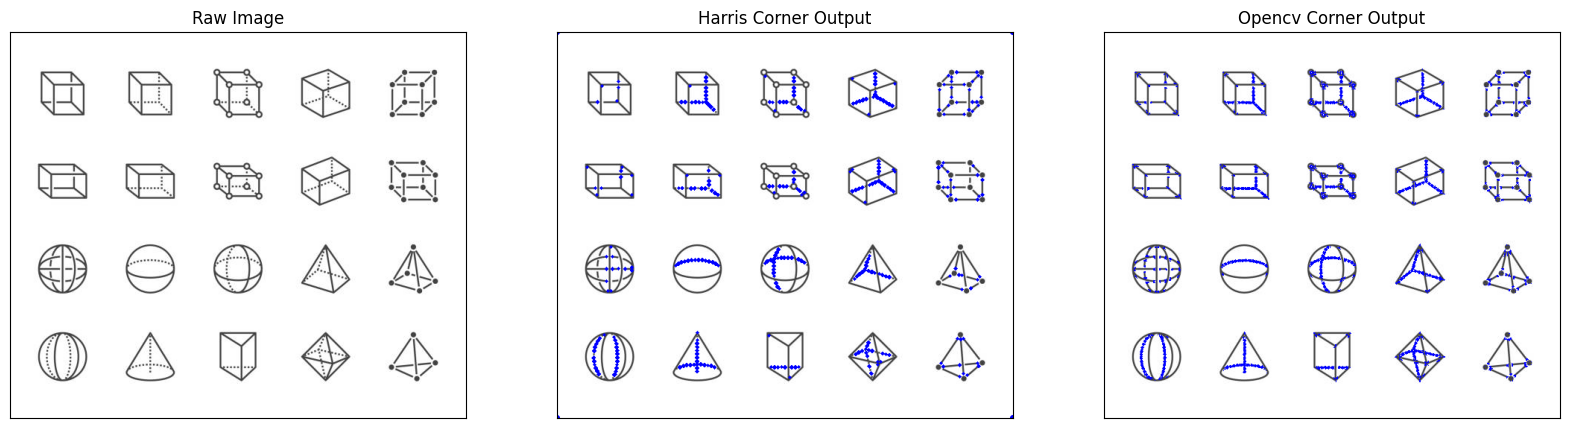

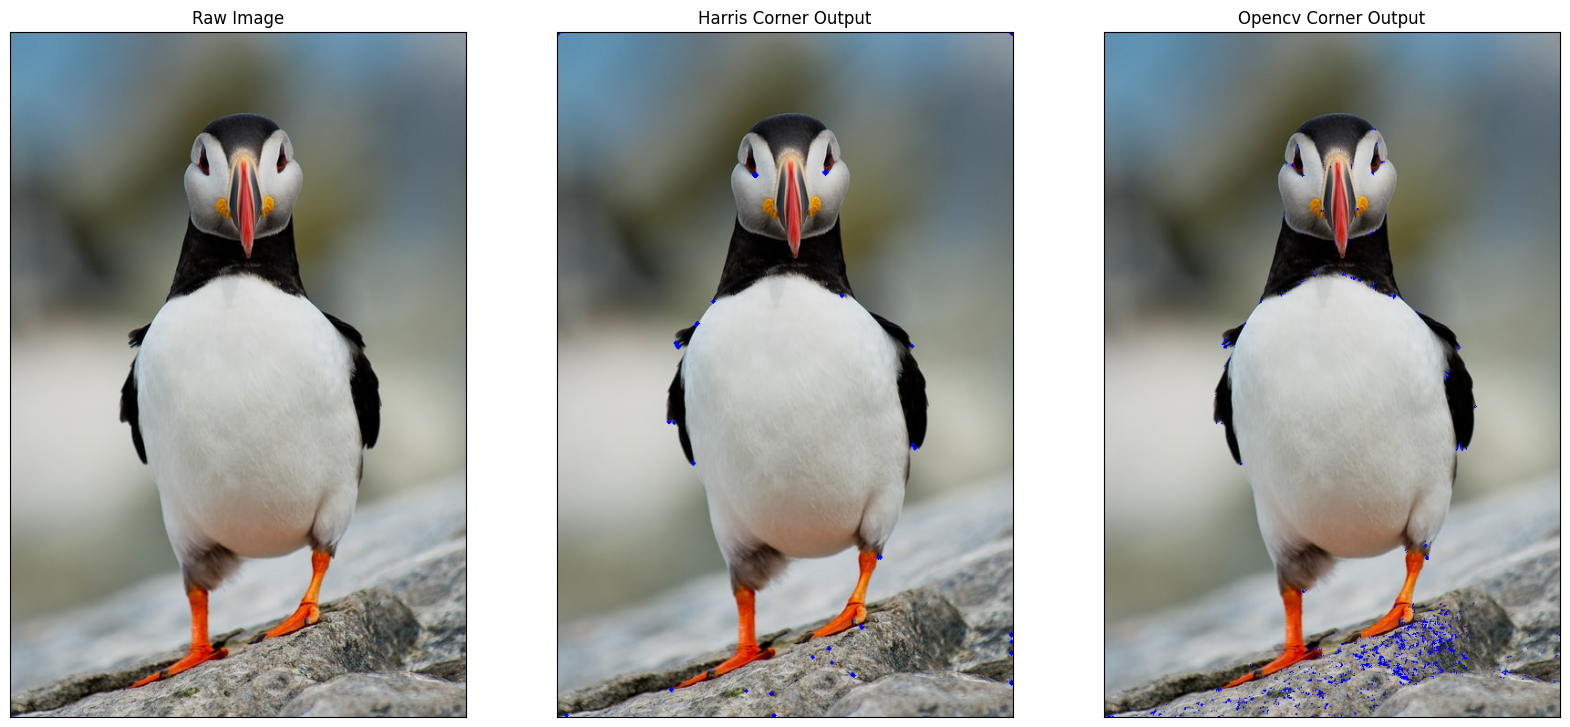

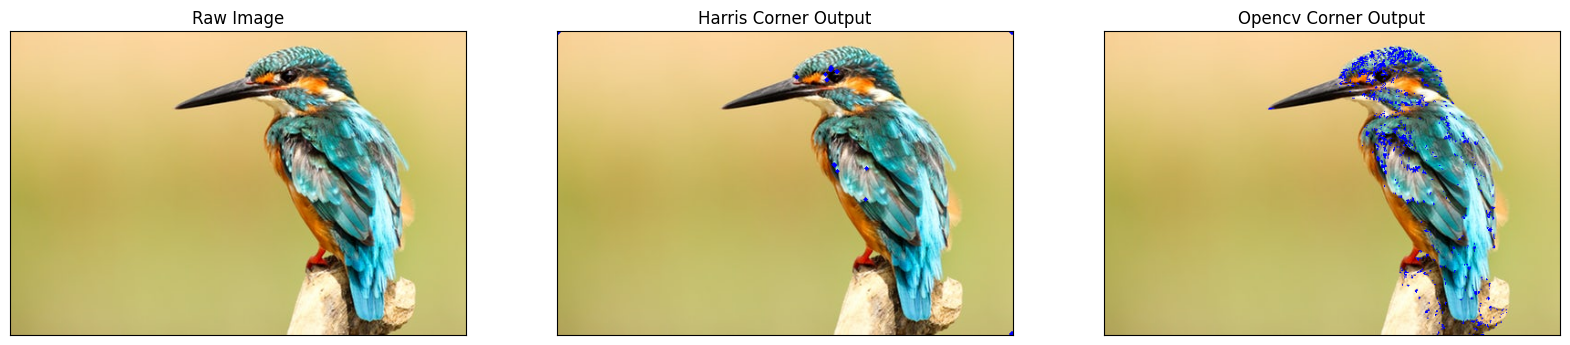

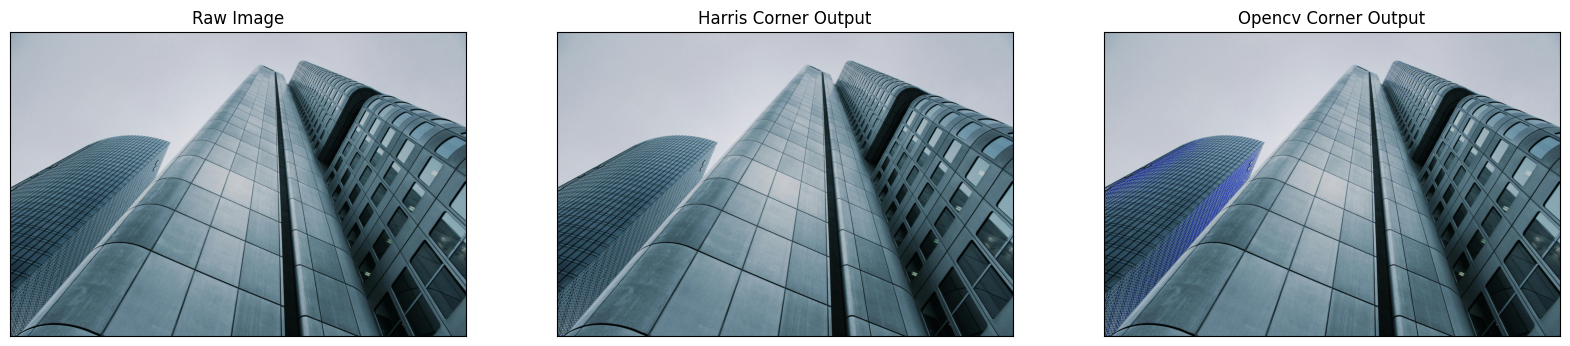

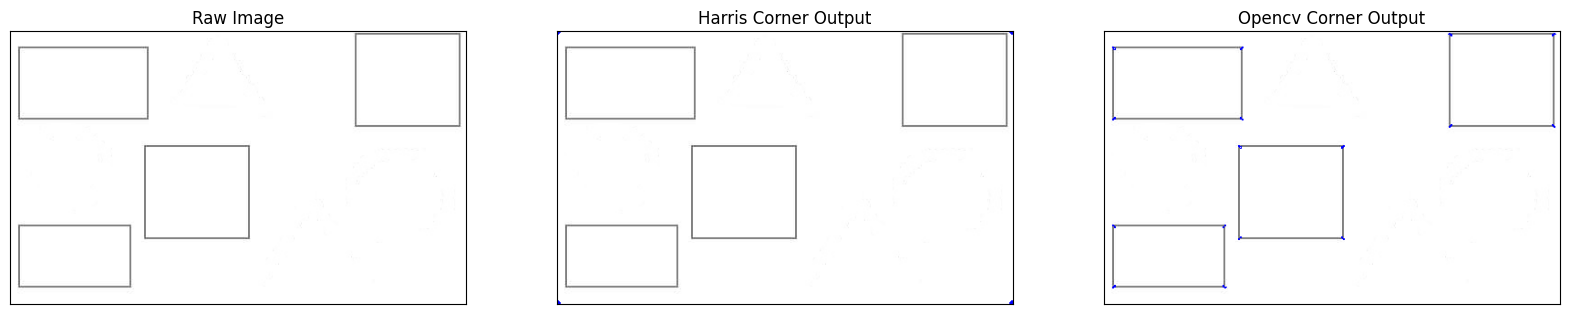

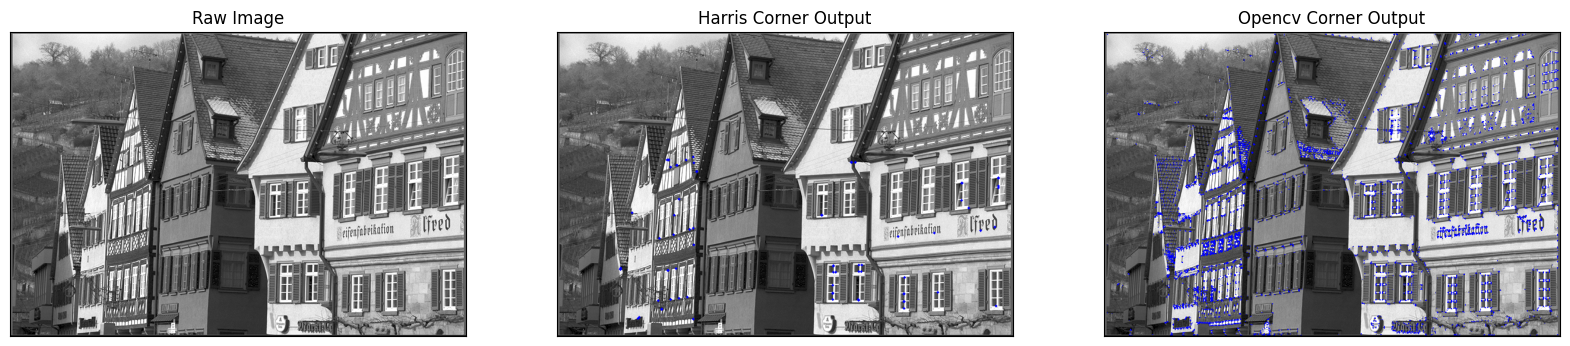

In [6]:
for i in range(len(corners_cv)):
    img = images[i]
    plt.figure(figsize=(20, 20))
    plt.subplot(1,3,1), plt.imshow(img)
    plt.title("Raw Image"), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,2), plt.imshow(corners_custom[i])
    plt.title("Harris Corner Output"), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,3), plt.imshow(corners_cv[i])
    plt.title("Opencv Corner Output"), plt.xticks([]), plt.yticks([])